In [1]:
# 使用 Hiroki Taniai 提供的预训练 Keras FaceNet 模型，
# 它是在 MS-Celeb-1M 数据集上训练的，并要求输入图像是彩色的，
# 其像素值要进行白噪化（在所有三个通道中进行标准化），并且具有 160x160 像素的正方形。
from tensorflow import keras
from PIL import Image
from mtcnn.mtcnn import MTCNN  # 使用 mtcnn 库创建人脸检测器并提取人脸
from os import listdir
from os.path import isdir
from numpy import asarray, load, expand_dims, savez_compressed
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice

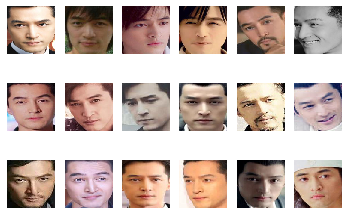

In [3]:
# 将从图片文件中加载照片，并返回提取的人脸。它假定照片包含一张人脸，并将返回检测到的第一张人脸。
def extract_face(filename, required_size=(160, 160)):
    # 使用 PIL 库 和 open() 函数来获取图像信息。
    # 将图像转换为 RGB，以防图像出现 alpha 通道或变成黑白。
    # 以 NumPy 数组的形式加载图像
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)

    # 创建一个 MTCNN 人脸检测器类，并使用它来检测加载的照片中所有的人脸。
    # create the detector, using default weights
    detector = MTCNN()

    # 结果是一个边界框列表，其中每个边界框定义了边界框的左下角，以及宽度和高度。
    results = detector.detect_faces(pixels)

    # 假设照片中只有一张人脸用于实验，可以确定边界框的像素坐标如下。
    # 有时候库会返回负像素索引，我认为这是一个 bug，可以通过取坐标的绝对值来解决这一问题。
    # extract the bounding box from the first face
    x1, y1, width, height = results[0].get("box")
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    # 使用这些坐标来提取人脸
    face = pixels[y1:y2, x1:x2]

    # 使用 PIL 库将这个人脸的小图像调整为所需的尺寸；具体而言，模型需要形状为 160x160 的正方形输入面。
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array


# specify folder to plot
folder = '5-celebrity-faces-dataset/train/huge/'
i = 1
# enumerate files
for filename in listdir(folder):
    path = folder + filename
    face = extract_face(path)
    pyplot.subplot(3, 6, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

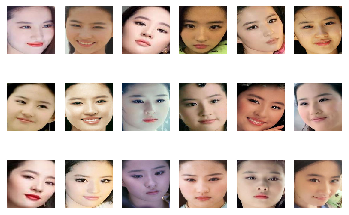

In [4]:
folder = '5-celebrity-faces-dataset/train/liuyifei/'
i = 1
# enumerate files
for filename in listdir(folder):
    path = folder + filename
    face = extract_face(path)
    pyplot.subplot(3, 6, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [5]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        # store
        faces.append(face)
    return faces


# 采用目录名称，如“5-celebrity-faces-dataset/train/”，并每个子目录（名人）检测人脸，为每个检测到的人脸分配标签。
def load_dataset(directory):
    X, y = list(), list()
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [6]:
# 加载“train”数据集中的所有照片，然后提取人脸，得到 93 （有一个样本异常）个样本，其中正方形人脸输入和类标签字符串作为输出。
# 然后加载“val ” 数据集，提供 25 个可用作测试数据集的样本。
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

# 将这两个数据集保存到“5-celebrity-faces-dataset.npz”的压缩 NymPy 数组文件中，该文件大约 3MB
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 18 examples for class: huge
>loaded 21 examples for class: jerry_seinfeld
>loaded 18 examples for class: liuyifei
>loaded 19 examples for class: madonna
>loaded 21 examples for class: mindy_kaling
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: huge
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: liuyifei
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
(128, 160, 160, 3) (128,) (35, 160, 160, 3) (35,)
Loaded:  (128, 160, 160, 3) (128,) (35, 160, 160, 3) (35,)


In [7]:
# 接下来，人脸转换为人脸嵌入
# load the facenet model
model = keras.models.load_model('facenet_keras.h5')
print('Loaded Model')
print(model.inputs)
print(model.outputs)

W0812 16:06:07.120613 10760 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Loaded Model
[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(?, 128) dtype=float32>]


In [8]:
# 给定一个人脸的图像和加载的 FaceNet 模型的情况下返回一个人脸嵌入
def get_embedding(model, face_pixels):
    # 为了预测嵌入，首先需要适当地准备图像的像素值，以满足 FaceNet 模型的要求。FaceNet 模型的这种特性实现要求像素是标准化的。
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std

    # 为了对 Keras 中的每一个样本进行预测，我们必须扩展维数，使人脸数组成为一个样本。
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)

    # 利用该模型进行预测，提取嵌入向量。
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [9]:
# 将训练数据集转换成 92个人脸嵌入，每个嵌入由 128 个元素向量组成。测试数据集中的 25 个样本也被适当地转换为人脸嵌入。
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

(128, 128)
(35, 128)
Dataset: train=128, test=35


In [10]:
# develop a classifier for the 5 Celebrity Faces Dataset
# 首先，对人脸嵌入向量进行归一化是一种很好的做法。这是一个很好的实践，因为向量通常使用距离度量进行比较。
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# 需要将每个名人姓名的字符串目标变量转换为整数。
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model 拟合一个模型。
# 在处理归一化人脸嵌入输入时，通常使用线性支持向量机（SVM）。这是因为该方法在分离人脸嵌入向量方面非常有效。
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
# 使用拟合模型对训练和测试数据集中的每个样本进行预测，然后计算分类正确率来实现。
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train * 100, score_test * 100))

Accuracy: train=100.000, test=100.000


In [12]:
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

Predicted: huge (86.419)
Expected: huge


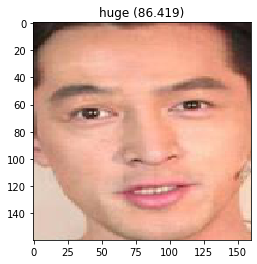

In [28]:
# 我们需要从测试集中随机选择一个样本，然后获取嵌入、人脸像素、期望的类预测以及类的相应名称。
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# 接下来，我们可以使用人脸嵌入作为输入，与拟合模型进行单个预测。
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0, class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()
